In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import pathlib
import itertools
import glob
import json

In [2]:
import monalysa
from monalysa import movements
from monalysa import quality

In [3]:
# Define the font family and size
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight

In [4]:
base_fig_dir = pathlib.Path.cwd().parent / "figures"

## Demonstration of the duration of movement

In [63]:
_t, _vel, _ = movements.generate_random_movement(move_type='Gaussian')
vel1 = np.hstack((np.zeros(40), _vel, np.zeros(25)))
dt = 0.01
T = len(vel1) * dt
t = np.arange(0, T, dt)
pos1 = 1.0 + np.cumsum(vel1) * dt

# Movement interval
_mi = 1.0* (vel1 > 0.01)
_tstrt = np.where(np.diff(_mi) == 1)[0]
_tstp = np.where(np.diff(_mi) == -1)[0]

In [67]:
print(T)

2.86


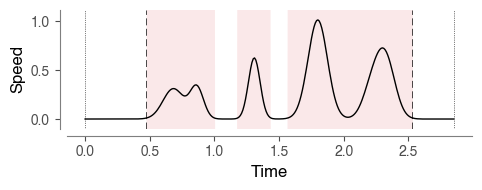

In [70]:
fig = plt.figure(figsize=(5, 2))

# Velocity plot
ax = fig.add_subplot(111)
ax.plot(t, vel1, color='k', lw=1)
# ax.step(t, _mi, color='tab:red', lw=1, alpha=0.2)
ax.fill(t, 10 * _mi - 5, color='tab:red', lw=0, alpha=0.1)
ax.axvline(t[_tstrt[0]], color='black', lw=0.5, ls="dashed", dashes=(10, 5))
ax.axvline(t[_tstp[-1]], color='black', lw=0.5, ls="dashed", dashes=(10, 5))
ax.axvline(0, color='black', lw=0.5, ls="dotted")
ax.axvline(t[-1], color='black', lw=0.5, ls="dotted")
# ax.set_xlim(0, T)
ax.set_ylim(-0.1, 1.1 * max(vel1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_ylabel("Speed", fontsize=12)
ax.set_xlabel("Time", fontsize=12)

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"duration_demo.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"duration_demo.svg"), bbox_inches="tight")


## Demonstration of Spatiotemporal Distance 

In [238]:
moves = {}

# Case 1
dt = 0.01
t = np.arange(0, 3 + dt, dt)
m1 = movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t, data_type="vel")
m2 = (m1 + np.random.normal(0, 0.5, len(m1))) * (m1 > 0)
m2 = np.abs(signal.savgol_filter(m2, window_length=21, polyorder=1, mode="constant")) * (m1 > 0)
m3 = movements.mjt_discrete_movement(amp=1, dur=1.25, loc=0.625, time=t, data_type="vel")
moves['case1'] = {
    "t": t,
    "m1": m1,
    "m2": m2,
    "m3": m3,
}

# Case 2
m1 = movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t, data_type="vel")
m2 = m1 + movements.mjt_discrete_movement(amp=0.5, dur=1.0, loc=1.75, time=t, data_type="vel")
m3 = m1 + movements.mjt_discrete_movement(amp=0.5, dur=1.0, loc=2.5, time=t, data_type="vel")
moves['case2'] = {
    "t": t,
    "m1": m1,
    "m2": m2,
    "m3": m3
}


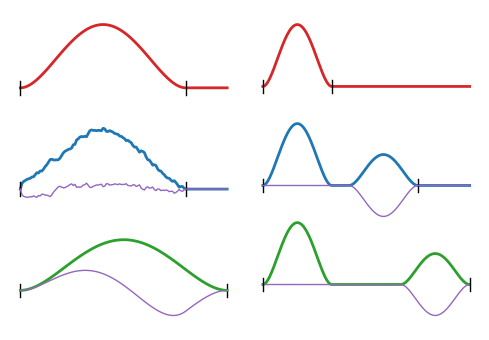

In [233]:
fig = plt.figure(figsize=(5, 3.5))
ydel = 3.0
ax = fig.add_subplot(121)
ax.plot(moves["case1"]["t"], moves["case1"]["m1"], color='tab:red',
        lw=2, label="$m_1$")
ax.plot([0, 0], [-0.2, 0.2], lw=1, color='k')
ax.plot([1, 1], [-0.2, 0.2], lw=1, color='k')
ax.plot(moves["case1"]["t"], moves["case1"]["m2"] - ydel, color='tab:blue',
        lw=2, label="$m_2$")
ax.plot([0, 0], [-0.2 - ydel, 0.2 - ydel], lw=1, color='k')
ax.plot([1, 1], [-0.2 - ydel, 0.2 - ydel], lw=1, color='k')
ax.plot(moves["case1"]["t"], moves["case1"]["m1"] - moves["case1"]["m2"] - ydel, 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.plot([0, 0], [-0.2 - 2 * ydel, 0.2 - 2 * ydel], lw=1, color='k')
ax.plot([1.25, 1.25], [-0.2 - 2 * ydel, 0.2 - 2 * ydel], lw=1, color='k')
ax.plot(moves["case1"]["t"], moves["case1"]["m3"] - 2 * ydel, color='tab:green',
        lw=2, label="$m_2$")
ax.plot(moves["case1"]["t"], moves["case1"]["m1"] - moves["case1"]["m3"] - 2 * ydel, 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.axis('off')

ax = fig.add_subplot(122)
ax.plot(moves["case2"]["t"], moves["case2"]["m1"], color='tab:red',
        lw=2, label="$m_1$")
ax.plot([0, 0], [-0.2, 0.2], lw=1, color='k')
ax.plot([1, 1], [-0.2, 0.2], lw=1, color='k')
ax.plot(moves["case2"]["t"], moves["case2"]["m2"] - ydel, color='tab:blue',
        lw=2, label="$m_2$")
ax.plot([0, 0], [-0.2 - ydel, 0.2 - ydel], lw=1, color='k')
ax.plot([2.25, 2.25], [-0.2 - ydel, 0.2 - ydel], lw=1, color='k')
ax.plot(moves["case2"]["t"], moves["case2"]["m1"] - moves["case2"]["m2"] - ydel, 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.plot(moves["case2"]["t"], moves["case2"]["m3"] - 2 * ydel, color='tab:green',
        lw=2, label="$m_2$")
ax.plot(moves["case2"]["t"], moves["case2"]["m1"] - moves["case2"]["m3"] - 2 * ydel, 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.plot([0, 0], [-0.2 - 2 * ydel, 0.2 - 2 * ydel], lw=1, color='k')
ax.plot([3.0, 3.0], [-0.2 - 2 * ydel, 0.2 - 2 * ydel], lw=1, color='k')
ax.axis('off')

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist.svg"), bbox_inches="tight")

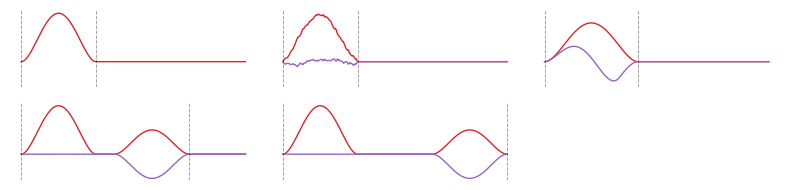

In [264]:
fig = plt.figure(figsize=(8, 2))
ax = fig.add_subplot(231)
ax.plot(moves["case1"]["t"], moves["case1"]["m1"], color='tab:red',
        lw=1, label="$m_1$")
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(1, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.set_ylim(-1.0, 2.0)
ax.axis('off')

ax = fig.add_subplot(232)
ax.plot(moves["case1"]["t"], moves["case1"]["m2"], color='tab:red',
        lw=1, label="$m_1$")
ax.plot(moves["case1"]["t"], moves["case1"]["m1"] - moves["case1"]["m2"], 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(1, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.set_ylim(-1.0, 2.0)
ax.axis('off')

ax = fig.add_subplot(233)
ax.plot(moves["case1"]["t"], moves["case1"]["m3"], color='tab:red',
        lw=1, label="$m_1$")
ax.plot(moves["case1"]["t"], moves["case1"]["m1"] - moves["case1"]["m3"], 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(1.25, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.set_ylim(-1.0, 2.0)
ax.axis('off')

ax = fig.add_subplot(234)
ax.plot(moves["case2"]["t"], moves["case2"]["m2"], color='tab:red',
        lw=1, label="$m_1$")
ax.plot(moves["case2"]["t"], moves["case2"]["m1"] - moves["case2"]["m2"], 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(2.25, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.set_ylim(-1.0, 2.0)
ax.axis('off')

ax = fig.add_subplot(235)
ax.plot(moves["case2"]["t"], moves["case2"]["m3"], color='tab:red',
        lw=1, label="$m_1$")
ax.plot(moves["case2"]["t"], moves["case2"]["m1"] - moves["case2"]["m3"], 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(3.0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.set_ylim(-1.0, 2.0)
ax.axis('off')

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_new.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_new.svg"), bbox_inches="tight")